# Human Activity Recognition

In [1]:
import json
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pydot
from plotly.graph_objects import Figure, Scatter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, LSTM, MaxPooling1D, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model, to_categorical

## 1. Setup Paths and Validate

In [2]:
base_dir = pathlib.Path.cwd().parent  # Adjust as needed
movements_dir = base_dir / "data" / "movements"
training_path = movements_dir / "training"
testing_path = movements_dir / "testing"

if not training_path.exists() or not testing_path.exists():
    raise FileNotFoundError("Training or testing directory not found.")

print(f"Training Path: {training_path}")
print(f"Testing Path: {testing_path}")

Training Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\data\movements\training
Testing Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\data\movements\testing


## 2. Load and Preprocess Training Data

In [3]:
training_files = list(training_path.glob("*.json"))
num_training_files = len(training_files)
samples_per_file = 625
training_signals = np.zeros((num_training_files * samples_per_file, 3))

for idx, file in enumerate(training_files):
    with open(file, 'r') as f:
        file_content = json.load(f)
    accelerometer_values = file_content['payload']['values']
    training_signals[idx * samples_per_file:(idx + 1) * samples_per_file] = accelerometer_values

print(f"Shape of training signals: {training_signals.shape}")

Shape of training signals: (30000, 3)


In [4]:
# Define class mapping
class_mapping = {
    'agitaraloslados': 0,
    'agitararribaabajo': 1,
    'brincar': 2,
    'caminar': 3,
    'circulos': 4,
    'trotar': 5
}

In [5]:
# Sampling rate calculation
sampling_rate = len(training_signals) / (10 * len(training_files))  # 10 seconds per file
print(f"Sampling Rate: {sampling_rate:.2f} Hz")

Sampling Rate: 62.50 Hz


In [6]:
# Visualize a sample for each class
for class_name in class_mapping.keys():
    file_sample = next((f for f in training_files if class_name in f.stem), None)
    if file_sample:
        with open(file_sample, 'r') as f:
            file_content = json.load(f)
        accelerometer_values = np.array(file_content['payload']['values'])
        time = np.arange(len(accelerometer_values)) / sampling_rate

        fig = Figure()
        fig.add_trace(Scatter(x=time, y=accelerometer_values[:, 0], mode='lines', name='AccX'))
        fig.add_trace(Scatter(x=time, y=accelerometer_values[:, 1], mode='lines', name='AccY'))
        fig.add_trace(Scatter(x=time, y=accelerometer_values[:, 2], mode='lines', name='AccZ'))
        fig.update_layout(
            title=f"Accelerometer Signals for Class: {class_name}",
            xaxis_title="Time (s)",
            yaxis_title="Acceleration (m/s²)",
            legend_title="Axis"
        )
        fig.show()

In [7]:
# Visualize combined accelerometer signals
time = np.arange(training_signals.shape[0]) / sampling_rate
fig = Figure()
fig.add_trace(Scatter(x=time, y=training_signals[:, 0], mode='lines', name='AccX'))
fig.add_trace(Scatter(x=time, y=training_signals[:, 1], mode='lines', name='AccY'))
fig.add_trace(Scatter(x=time, y=training_signals[:, 2], mode='lines', name='AccZ'))
fig.update_layout(
    title="Combined Accelerometer Signals - Training Data",
    xaxis_title="Time (s)",
    yaxis_title="Acceleration (m/s²)",
    legend_title="Axis"
)
fig.show()

In [8]:
# Normalize training data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_signals = scaler.fit_transform(training_signals)

In [9]:
# Visualize normalized training signals
fig = Figure()
fig.add_trace(Scatter(x=time, y=normalized_signals[:, 0], mode='lines', name='AccX'))
fig.add_trace(Scatter(x=time, y=normalized_signals[:, 1], mode='lines', name='AccY'))
fig.add_trace(Scatter(x=time, y=normalized_signals[:, 2], mode='lines', name='AccZ'))
fig.update_layout(
    title="Normalized Accelerometer Signals - Training Data",
    xaxis_title="Time (s)",
    yaxis_title="Normalized Acceleration",
    legend_title="Axis"
)
fig.show()

In [11]:
# Divide into windows
window_size = 104
total_windows = normalized_signals.shape[0] // window_size
X_train = np.zeros((total_windows, window_size, 3))

for i in range(total_windows):
    X_train[i, :, :] = normalized_signals[i * window_size:(i + 1) * window_size]

In [12]:
# Visualize a random window from normalized training data
random_window = np.random.randint(0, X_train.shape[0])
window_time = np.arange(window_size) / sampling_rate

fig = Figure()
fig.add_trace(Scatter(x=window_time, y=X_train[random_window, :, 0], mode='lines', name='AccX'))
fig.add_trace(Scatter(x=window_time, y=X_train[random_window, :, 1], mode='lines', name='AccY'))
fig.add_trace(Scatter(x=window_time, y=X_train[random_window, :, 2], mode='lines', name='AccZ'))
fig.update_layout(
    title="Random Window from Normalized Training Data",
    xaxis_title="Time (s)",
    yaxis_title="Normalized Acceleration",
    legend_title="Axis"
)
fig.show()

In [13]:
# Generate labels
labels = []
for file in training_files:
    for class_name in class_mapping:
        if class_name in file.stem:
            labels.append(class_mapping[class_name])
            break
    else:
        raise ValueError(f"Unknown class name in file: {file.stem}")

labels = np.array(labels).repeat(X_train.shape[0] // num_training_files).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(labels)

In [14]:
# Flatten training data for MLP
X_train_flat = X_train.reshape(X_train.shape[0], -1)

## 3. Build and Train the MLP Model

In [15]:
mlp_model = Sequential([
    Input(shape=(X_train_flat.shape[1],)),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(len(class_mapping), activation="softmax")
])

In [16]:
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        80,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,670 (475.27 KB)

 Trainable params: 121,670 (475.27 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
mlp_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
plot_model(mlp_model, show_shapes=True, show_layer_names=True, to_file="MLP_architecture.png", show_layer_activations=True)
mlp_history = mlp_model.fit(X_train_flat, y_train, epochs=60, batch_size=32, verbose=1)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1767 - loss: 1.8314
Epoch 2/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2294 - loss: 1.6875 
Epoch 3/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3201 - loss: 1.6131
Epoch 4/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.3375 - loss: 1.4766
Epoch 5/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4120 - loss: 1.3646
Epoch 6/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4624 - loss: 1.2786
Epoch 7/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5173 - loss: 1.1608
Epoch 8/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5975 - loss: 1.0982
Epoch 9/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 0.9873
Epoch 10/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6306 - loss: 0.9404
Epoch 11/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.64

In [18]:
# Plot MLP training loss
fig = Figure()
fig.add_trace(Scatter(x=list(range(1, 61)), y=mlp_history.history['loss'], mode='lines', name='Loss'))
fig.update_layout(
    title="MLP Training Loss Over Epochs",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    legend_title="Metric"
)
fig.show()

## 4. Build and Train the Convolutional Model

In [19]:
conv_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(16, kernel_size=3, activation="relu", padding="same"),
    Conv1D(32, kernel_size=3, activation="relu", padding="same"),
    Conv1D(64, kernel_size=3, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(len(class_mapping), activation="softmax")
])

In [20]:
conv_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 104, 16)        │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 104, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 104, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 52, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3328)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       426,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,822 (1.66 MB)

 Trainable params: 434,822 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
conv_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
plot_model(conv_model, show_shapes=True, show_layer_names=True, to_file="CNN_architecture.png", show_layer_activations=True)
conv_history = conv_model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2173 - loss: 1.7858
Epoch 2/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4744 - loss: 1.5740
Epoch 3/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6876 - loss: 1.1796 
Epoch 4/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6849 - loss: 0.8499 
Epoch 5/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8105 - loss: 0.6249 
Epoch 6/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9105 - loss: 0.4465 
Epoch 7/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9107 - loss: 0.3287 
Epoch 8/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9014 - loss: 0.2974 
Epoch 9/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9495 - loss: 0.2397 
Epoch 10/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9570 - loss: 0.2272 
Epoch 11/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

In [22]:
# Plot CNN training loss
fig = Figure()
fig.add_trace(Scatter(x=list(range(1, 61)), y=conv_history.history['loss'], mode='lines', name='Loss'))
fig.update_layout(
    title="CNN Training Loss Over Epochs",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    legend_title="Metric"
)
fig.show()

## 5. Build and Train the SimpleRNN Model

In [23]:
rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(128, activation="relu", return_sequences=True),
    SimpleRNN(64, activation="relu"),
    Dense(len(class_mapping), activation="softmax")
])

In [24]:
rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 104, 128)       │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,638 (115.77 KB)

 Trainable params: 29,638 (115.77 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
rnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
plot_model(rnn_model, show_shapes=True, show_layer_names=True, to_file="RNN_architecture.png", show_layer_activations=True)
rnn_history = rnn_model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1525 - loss: 1.8011
Epoch 2/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1566 - loss: 1.7727
Epoch 3/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2689 - loss: 1.6905
Epoch 4/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3593 - loss: 1.5468
Epoch 5/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2136 - loss: 1.7870
Epoch 6/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2397 - loss: 1.7000
Epoch 7/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1977 - loss: 1.7824
Epoch 8/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2673 - loss: 1.7678
Epoch 9/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2376 - loss: 1.7405
Epoch 10/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2496 - loss: 1.6954
Epoch 11/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accura

In [26]:
# Plot RNN training loss
fig = Figure()
fig.add_trace(Scatter(x=list(range(1, 61)), y=rnn_history.history['loss'], mode='lines', name='Loss'))
fig.update_layout(
    title="RNN Training Loss Over Epochs",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    legend_title="Metric"
)
fig.show()

## 6. Build and Train the LSTM Model

In [27]:
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, activation="relu", return_sequences=True),
    LSTM(64, activation="relu"),
    Dense(len(class_mapping), activation="softmax")
])

In [28]:
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 104, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,382 (458.52 KB)

 Trainable params: 117,382 (458.52 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
lstm_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
plot_model(lstm_model, show_shapes=True, show_layer_names=True, to_file="LSTM_architecture.png", show_layer_activations=True)
lstm_history = lstm_model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.2047 - loss: 1.7925
Epoch 2/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.1858 - loss: 1.7849
Epoch 3/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.1982 - loss: 1.7731
Epoch 4/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3347 - loss: 17859.3105
Epoch 5/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.1291 - loss: 1.6966
Epoch 6/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.1385 - loss: 6.2224
Epoch 7/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.2732 - loss: 1.7618
Epoch 8/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3203 - loss: 1.7640
Epoch 9/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.3256 - loss: 1.7660
Epoch 10/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.2550 - loss: 1.7687
Epoch 11/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/st

In [30]:
# Plot LSTM training loss
fig = Figure()
fig.add_trace(Scatter(x=list(range(1, 61)), y=lstm_history.history['loss'], mode='lines', name='Loss'))
fig.update_layout(
    title="LSTM Training Loss Over Epochs",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    legend_title="Metric"
)
fig.show()

## 7. Validation and Testing

In [31]:
# Load and process testing data
validation_files = list(testing_path.glob("*.json"))
num_validation_files = len(validation_files)
validation_signals = np.zeros((num_validation_files * 624, 3))

for idx, file in enumerate(validation_files):
    dataframe = pd.read_json(file)
    values = dataframe.iloc[:, :].values
    extracted_values = values[7, 2][0:-1]
    validation_signals[idx * 624:(idx + 1) * 624] = np.array(extracted_values)

# Normalize testing data
validation_signals_scaled = scaler.transform(validation_signals)

In [32]:
# Divide testing data into windows
num_test_windows = validation_signals_scaled.shape[0] // window_size
X_test = np.zeros((num_test_windows, window_size, 3))

for i in range(num_test_windows):
    X_test[i, :, :] = validation_signals_scaled[i * window_size:(i + 1) * window_size]

# Generate labels for testing data
test_labels = []
for file in validation_files:
    for class_name in class_mapping:
        if class_name in file.stem:
            test_labels.append(class_mapping[class_name])
            break

test_labels = np.array(test_labels).repeat(X_test.shape[0] // num_validation_files).reshape(-1, 1)
y_test = to_categorical(test_labels, num_classes=len(class_mapping))

# Flatten test data for MLP
X_test_flat = X_test.reshape(X_test.shape[0], -1)

## 8. Evaluate Models on Test Data

In [33]:
# Evaluate MLP
mlp_evaluation = mlp_model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss (MLP): {mlp_evaluation[0]:.4f}")
print(f"Test Accuracy (MLP): {mlp_evaluation[1]:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8455 - loss: 0.3438  
Test Loss (MLP): 0.3994
Test Accuracy (MLP): 0.8472


In [34]:
# Evaluate CNN
cnn_evaluation = conv_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (CNN): {cnn_evaluation[0]:.4f}")
print(f"Test Accuracy (CNN): {cnn_evaluation[1]:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9557 - loss: 0.0672 
Test Loss (CNN): 0.0820
Test Accuracy (CNN): 0.9583


In [35]:
# Evaluate RNN
rnn_evaluation = rnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (RNN): {rnn_evaluation[0]:.4f}")
print(f"Test Accuracy (RNN): {rnn_evaluation[1]:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5282 - loss: 1.2980 
Test Loss (RNN): 1.3528
Test Accuracy (RNN): 0.4861


In [36]:
# Evaluate LSTM
lstm_evaluation = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (LSTM): {lstm_evaluation[0]:.4f}")
print(f"Test Accuracy (LSTM): {lstm_evaluation[1]:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2179 - loss: 1.7109
Test Loss (LSTM): 1.7049
Test Accuracy (LSTM): 0.2639


## 9. Classification Reports

In [37]:
# Predictions for all models
y_mlp_pred_classes = np.argmax(mlp_model.predict(X_test_flat), axis=1)
y_cnn_pred_classes = np.argmax(conv_model.predict(X_test), axis=1)
y_rnn_pred_classes = np.argmax(rnn_model.predict(X_test), axis=1)
y_lstm_pred_classes = np.argmax(lstm_model.predict(X_test), axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002227D20D3A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


In [38]:
# Ground truth classes
y_test_classes = np.argmax(y_test, axis=1)

In [39]:
# MLP Classification Report
print("MLP Classification Report:")
print(classification_report(y_test_classes, y_mlp_pred_classes, target_names=list(class_mapping.keys()), zero_division=0))

MLP Classification Report:
                   precision    recall  f1-score   support

  agitaraloslados       1.00      1.00      1.00        12
agitararribaabajo       1.00      0.75      0.86        12
          brincar       0.80      0.67      0.73        12
          caminar       0.75      1.00      0.86        12
         circulos       0.71      1.00      0.83        12
           trotar       1.00      0.67      0.80        12

         accuracy                           0.85        72
        macro avg       0.88      0.85      0.84        72
     weighted avg       0.88      0.85      0.84        72



In [40]:
# CNN Classification Report
print("CNN Classification Report:")
print(classification_report(y_test_classes, y_cnn_pred_classes, target_names=list(class_mapping.keys()), zero_division=0))

CNN Classification Report:
                   precision    recall  f1-score   support

  agitaraloslados       1.00      1.00      1.00        12
agitararribaabajo       1.00      0.83      0.91        12
          brincar       1.00      1.00      1.00        12
          caminar       1.00      1.00      1.00        12
         circulos       0.80      1.00      0.89        12
           trotar       1.00      0.92      0.96        12

         accuracy                           0.96        72
        macro avg       0.97      0.96      0.96        72
     weighted avg       0.97      0.96      0.96        72



In [41]:
# RNN Classification Report
print("RNN Classification Report:")
print(classification_report(y_test_classes, y_rnn_pred_classes, target_names=list(class_mapping.keys()), zero_division=0))

RNN Classification Report:
                   precision    recall  f1-score   support

  agitaraloslados       0.88      0.58      0.70        12
agitararribaabajo       0.35      0.67      0.46        12
          brincar       0.56      0.42      0.48        12
          caminar       0.57      1.00      0.73        12
         circulos       0.30      0.25      0.27        12
           trotar       0.00      0.00      0.00        12

         accuracy                           0.49        72
        macro avg       0.44      0.49      0.44        72
     weighted avg       0.44      0.49      0.44        72



In [42]:
# LSTM Classification Report
print("LSTM Classification Report:")
print(classification_report(y_test_classes, y_lstm_pred_classes, target_names=list(class_mapping.keys()), zero_division=0))

LSTM Classification Report:
                   precision    recall  f1-score   support

  agitaraloslados       0.00      0.00      0.00        12
agitararribaabajo       0.67      0.33      0.44        12
          brincar       0.00      0.00      0.00        12
          caminar       0.00      0.00      0.00        12
         circulos       0.60      0.50      0.55        12
           trotar       0.18      0.75      0.29        12

         accuracy                           0.26        72
        macro avg       0.24      0.26      0.21        72
     weighted avg       0.24      0.26      0.21        72



## 10. Confusion Matrix Plots

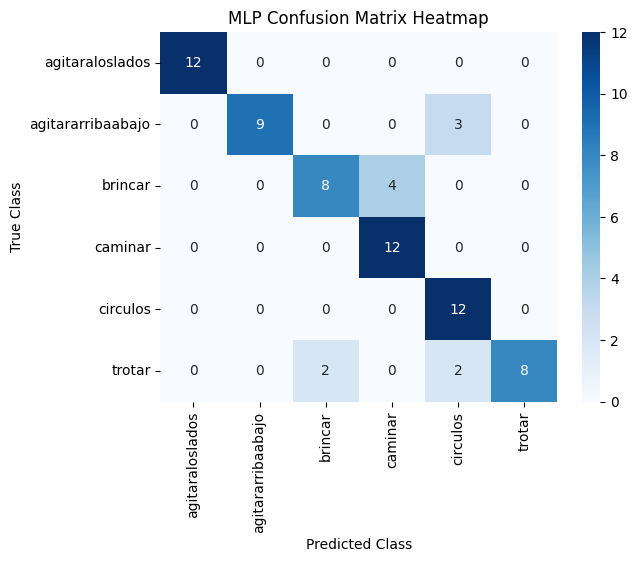

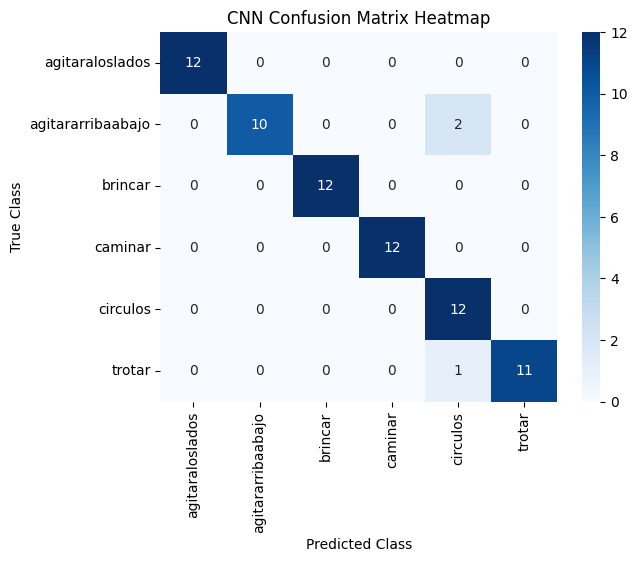

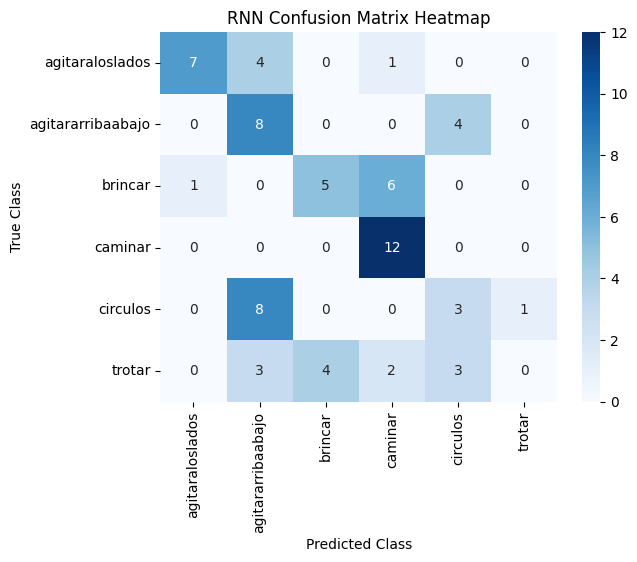

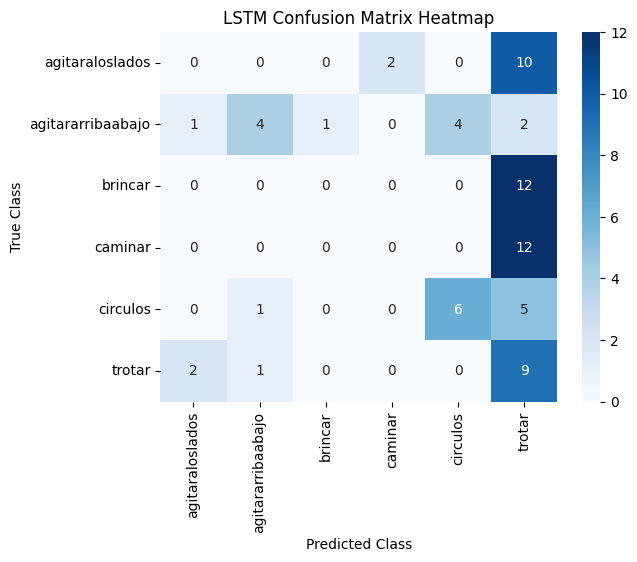

In [43]:
# Confusion matrices for all models
models_predictions = {
    "MLP": y_mlp_pred_classes,
    "CNN": y_cnn_pred_classes,
    "RNN": y_rnn_pred_classes,
    "LSTM": y_lstm_pred_classes
}

for model_name, predictions in models_predictions.items():
    confusion_mtx = confusion_matrix(y_test_classes, predictions)
    sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
    plt.title(f"{model_name} Confusion Matrix Heatmap")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()